# Group1 Consulting
## See Through the Ambiguity: Predicting Home Prices

Group1 Consulting has been approached by a real estate investement agency who is requesting an algorithm that predicts home prices. The real estate investment firm FlatTech RealEstate, buys homes in the Austin area. They have tasked our team with finding a datafile, clean it, and run various algorithms to create an home price predictor. Our algorith will predict home prices based on common features of home listings like number of beds, baths, lot size, square footage, etc. to help both buyers and sellers see through the ambiguity in home pricing.

This notebook is being run in Google Co-Lab for versioning control.

## The Dataset
The dataset we're using is the Austin TX, House Listing dataset off Kaggle, created by Eric Pierce. The dataset has been uploaded to one of our teams branches so we'll drill into here to upload it to the notebook. Here is the link to the actual Kaggle page:
https://www.kaggle.com/datasets/ericpierce/austinhousingprices

In [ ]:
# Use wget to pull in the dataset into the notebook
!wget https://raw.githubusercontent.com/hixtape1212/Group1Capstone/Gerardo/Austin_notebooks/austinHousingData.csv

--2023-07-28 18:22:30--  https://raw.githubusercontent.com/hixtape1212/Group1Capstone/Gerardo/Austin_notebooks/austinHousingData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11389525 (11M) [text/plain]
Saving to: ‘austinHousingData.csv.2’

austinHousingData.c 100%[===================>]  10.86M  --.-KB/s    in 0.1s    

2023-07-28 18:22:30 (88.0 MB/s) - ‘austinHousingData.csv.2’ saved [11389525/11389525]



### Importing the Nessesary Librarys for Analysis
Since Kera's is required to create Nueral Networks later in this notebook, we need to control versioning, which is why Google Co-Lab is the prime choice to run this notebook. Below we'll import the nessesary libraries.

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.api._v2.keras import activations
from tensorflow.keras.optimizers.schedules import ExponentialDecay

print(tf.__version__)

2.12.0


In [ ]:
#Creating a dataframe for the dataset
file_path = 'austinHousingData.csv'
df = pd.read_csv(file_path)

## EDA and Cleaning
Let's take a look at the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

Initially we see that the data is very clean, with no non-null values. Our client is only interested in single family homes. Let's get rid of any homes that don't fit that description.

In [ ]:
#Let's look at the home types. We primarily only want single family homes
df.homeType.value_counts()

Single Family            14241
Condo                      470
Townhouse                  174
Multiple Occupancy          96
Vacant Land                 83
Residential                 37
Apartment                   37
Mobile / Manufactured       17
MultiFamily                 10
Other                        6
Name: homeType, dtype: int64

In [ ]:
df = df[df.homeType == 'Single Family']
df.shape

(14241, 47)

 Also, for our purposes columns like zpid which is the default primary key zillow uses to identify homes can be gotten rid of. Additionally it would be good to only use numeric values as they are the only values our models can use to train.

Most of the object types here are redudant and the information gathered can be explained by another numeric feature, like City can be explained through zip code etc. We can drop those.

Also boolean values can be changed into numeric 0 and 1 for our processing purposes. We can do both of these things below.

In [ ]:
#Drop object columns as well as zipid
col_drop_list = df.select_dtypes(include=[np.object]).keys()
col_drop_list = col_drop_list.union(['zpid'])
df = df.drop(col_drop_list, axis=1)
df.shape

<ipython-input-7-421071a199b5>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col_drop_list = df.select_dtypes(include=[np.object]).keys()


(14241, 39)

In [ ]:
#Changing Booleans to int values, then dropping the boolean columns
col_bool_list = ['hasAssociation', 'hasCooling',
                 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for col in col_bool_list:
    name = col + '_int'
    df[name] = df[col].astype(int)

df = df.drop(col_bool_list, axis=1)
df.shape

(14241, 39)

### Dealing with Outliers
Now that our dataset is all numeric, let's take a look at the key feature statistics and see if their are any heavy outliers. Keep in mind we're trying to predict home pricing.

In [ ]:
#Take a look at the descriptive stats
df.describe().transpose().apply(lambda x: x.apply('{0:f}'.format))

,count,mean,std,min,25%,50%,75%,max
zipcode,14241.000000,78736.186785,18.721340,78617.000000,78727.000000,78739.000000,78749.000000,78759.000000
latitude,14241.000000,30.291740,0.098383,30.085030,30.201195,30.284163,30.367920,30.517174
longitude,14241.000000,-97.780411,0.085880,-98.022057,-97.841804,-97.771988,-97.718689,-97.569504
propertyTaxRate,14241.000000,1.994731,0.054207,1.980000,1.980000,1.980000,1.980000,2.210000
garageSpaces,14241.000000,1.236851,1.343474,0.000000,0.000000,1.000000,2.000000,20.000000
parkingSpaces,14241.000000,1.236219,1.343612,0.000000,0.000000,1.000000,2.000000,20.000000
yearBuilt,14241.000000,1988.408749,21.555337,1905.000000,1974.000000,1993.000000,2006.000000,2020.000000
latestPrice,14241.000000,516387.884629,446969.176124,5500.000000,310000.000000,409900.000000,575000.000000,13500000.000000
numPriceChanges,14241.000000,3.044730,2.491960,1.000000,1.000000,2.000000,4.000000,23.000000
latest_salemonth,14241.000000,6.728039,3.134325,1.000000,4.000000,7.000000,9.000000,12.000000


If you notice, the latest prices ranges from 5500 dollars to 13.5 million! This is a large gap and could heavily skew our model. Let's look and see if we can narrow that down by looking at the column on a normal distribution and finding the inner 90 and 95 percent ranges.

In [ ]:
#Narrowing this down can help our model. Lets look at the mid 80 & 90%
upper = np.percentile(df.latestPrice, 90)
lower = np.percentile(df.latestPrice, 10)

print('Middle 80 are values between {} and {}'.format(lower, upper))

upper = np.percentile(df.latestPrice, 95)
lower = np.percentile(df.latestPrice, 5)

print('Middle 90 are values between {} and {}'.format(lower, upper))

Middle 80 are values between 240000.0 and 840000.0
Middle 90 are values between 207000.0 and 1175000.0


The middle 90% of the home values are between 207,000 and 1,175,000. If we move the lower bound down I think we should be looking at home from 200,000 to 1.1 million, covering roughly 90% of our data.

In [ ]:
#Dropping values between 200k and 1.175M
df = df.drop(df[df['latestPrice'] < 200000].index)
df = df.drop(df[df['latestPrice'] > 1175000].index)
df.shape

(12907, 39)

## Final Pre-Processing
Now that our dataset is where we want it to be, the final part before creating a model will be too create the test and training sets, as well as normalize the data. Below we will do both of those.

In [ ]:
#Creating Train and Test splits
X = df.drop('latestPrice', axis='columns')
y = df.latestPrice
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=42)

In [ ]:
#Normalizing the input data
sc = MinMaxScaler(feature_range=(0,1))
X_norm_train = sc.fit_transform(X_train)
X_norm_test = sc.fit_transform(X_test)

## Linear Regression

## Nueral Networking
The nueral networking approach is more complex than linear regression. Still using RMSE, MSE, and MAE as evaluation metrics, the model can take a long time to compute as well as be hard to interprate exactly what is going on. We will create a basic model first, and start to build more complex model to try and minimize our evaluation metrics.

### Creating a visualization tool
First we'll create a function that takes a model's training history and output two graphs describing the MSE and MAE of our training and validation sets. This way we can easily see visually how the model is performing.

In [ ]:
#Creating plotting function to evaluate models
def plot_results(r):
  hist = pd.DataFrame(r.history)
  hist['epoch'] = r.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE of House Price')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label='Validation Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE of House Price')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label='Validation Error')
  plt.legend()

### Model Creation
Now let's create our first basic model

In [ ]:
#First Model with relu as activation, simple architecture, and adam as optimizer
def build_model():
  model = keras.Sequential([
      layers.Dense(40, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dense(20, activation=tf.nn.relu),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse']
  )

  return model

In [ ]:
# Instantiate the model and look at summary
v1_model = build_model()
v1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1560      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


Testing set Mean Abs Error: 206578.23 dollars
Testing set Root Mean Squared Error: 261702.75 dollars


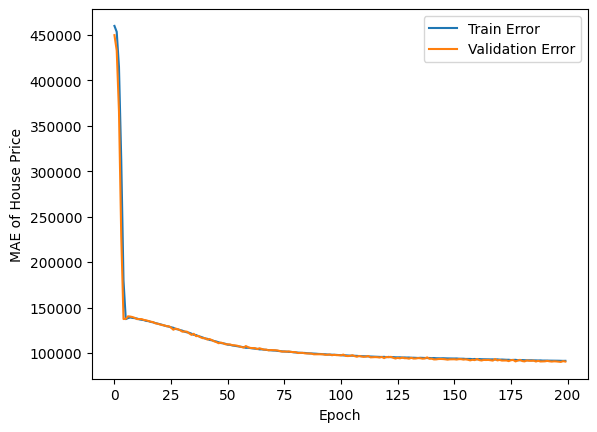

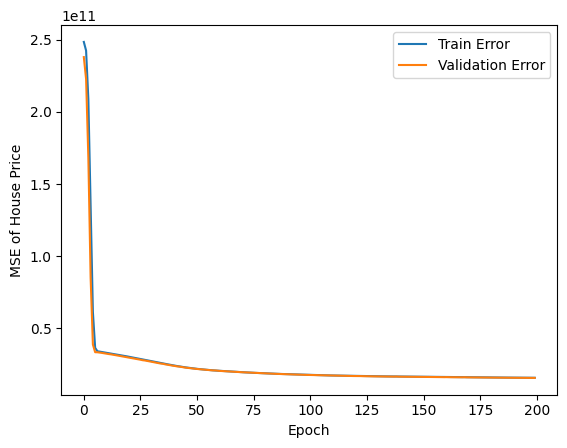

In [ ]:
#Train and view model results
v1_history = v1_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0)
plot_results(v1_history)

v1_loss, v1_mae, v1_mse = v1_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v1_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v1_mse)))

Overall the model seemed to perform well. It starts to bottom out on performance after 50 epochs, so it might be useful to add in a dynamic of early stopping to the model in order to stop it from overtraining and taking longer than it needs too.

In [ ]:
# Create the early stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# Create a new model with Early Stopping
def build_model():
  model = keras.Sequential([
      layers.Dense(40, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dense(20, activation=tf.nn.relu),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse'],
  )

  return model

In [ ]:
# Instantiate the model and look at summary
v2_model = build_model()
v2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                1560      
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


Testing set Mean Abs Error: 191062.78 dollars
Testing set Root Mean Squared Error: 248889.50 dollars


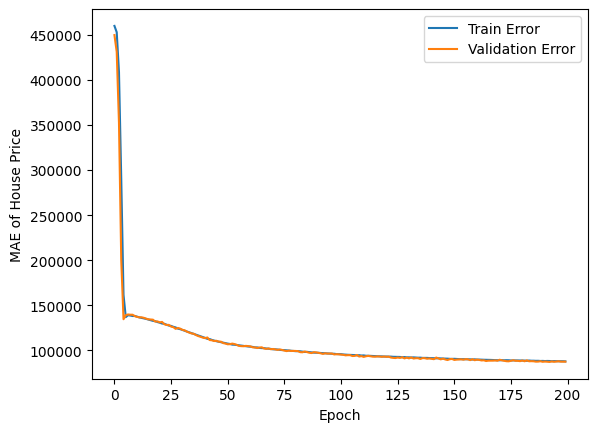

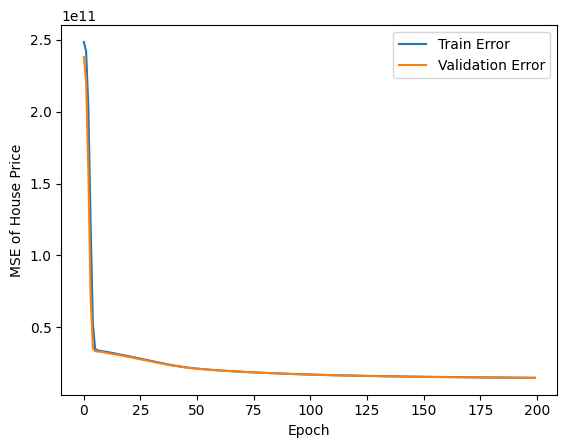

In [ ]:
#Train and view model results, with early stopping
v2_history = v2_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0,
                          callbacks=[early_stop])
plot_results(v2_history)

v2_loss, v2_mae, v2_mse = v2_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v2_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v2_mse)))

The model seemed to have performed better in terms of MAE and RMSE, but the early stopping never kicked in. Let's make the model more complex, with longer epochs and a deeper network and see if we can again reduce the MAE and RMSE.

In [ ]:
# Create a more complex model
def build_model():
  model = keras.Sequential([
      layers.Dense(350, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
      layers.Dense(175, activation=tf.nn.relu),
      layers.Dense(100, activation=tf.nn.relu),
      layers.Dense(50, activation=tf.nn.relu),
      layers.Dense(25, activation=tf.nn.relu),
      layers.Dense(10, activation=tf.nn.relu),
      layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(
      loss = 'mse',
      optimizer=optimizer,
      metrics=['mae','mse'],
  )

  return model

In [ ]:
# Instantiate the model and look at summary
v3_model = build_model()
v3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 350)               13650     
                                                                 
 dense_13 (Dense)            (None, 175)               61425     
                                                                 
 dense_14 (Dense)            (None, 100)               17600     
                                                                 
 dense_15 (Dense)            (None, 50)                5050      
                                                                 
 dense_16 (Dense)            (None, 25)                1275      
                                                                 
 dense_17 (Dense)            (None, 10)                260       
                                                                 
 dense_18 (Dense)            (None, 1)                

Testing set Mean Abs Error: 202829.45 dollars
Testing set Root Mean Squared Error: 259148.23 dollars


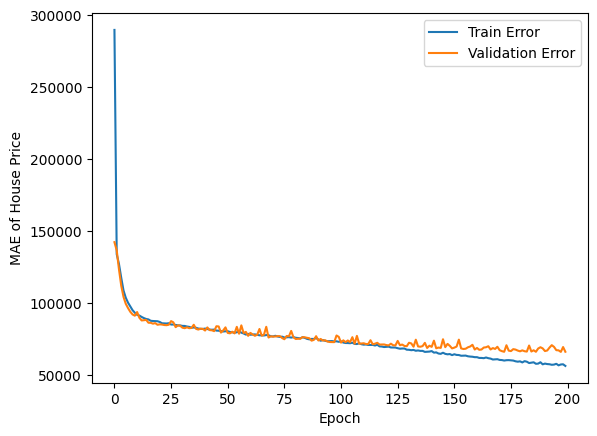

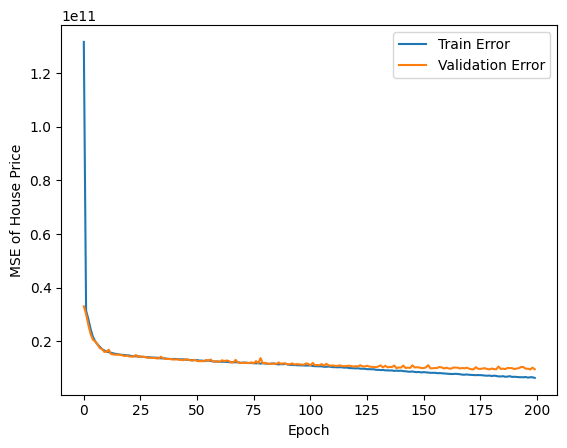

In [ ]:
#Train and view model results, with early stopping
v3_history = v3_model.fit(X_norm_train, y_train,
                          epochs=200,
                          validation_split=.2,
                          verbose=0,
                          callbacks=[early_stop])
plot_results(v3_history)

v3_loss, v3_mae, v3_mse = v3_model.evaluate(X_norm_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} dollars'.format(v3_mae))
print('Testing set Root Mean Squared Error: {:5.2f} dollars'.format(np.sqrt(v3_mse)))

The larger model didn't seem to yeild better results in either RMSE and MAE. Another critque we could do is adjusting the learning rate of the model. This could allow the model to change it's outer nodes more frequently and perhaps yeild a better result.